# implement PINN using only Phyisc loss, this code is still under developing
#Author : Manal ALghamdi
#Date : 12 Nov 2024"""

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [233]:
class MLP(nn.Module):
    def __init__(self, hidden_layers, neurons_per_layer):
        super(MLP, self).__init__()

        self.input_layer = nn.Linear(4, neurons_per_layer)  # 4 inputs: t, U0, W0, K
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(neurons_per_layer, neurons_per_layer) for _ in range(hidden_layers)])
        self.output_layer = nn.Linear(neurons_per_layer, 2)  # 2 outputs: U, W

        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output_layer(x)

MLP_model = MLP(hidden_layers=2, neurons_per_layer=5)
optimizer = optim.Adam(MLP_model.parameters(), lr=1e-3)

In [234]:
def Physic_Loss (t_current, U0_current, W0_current, K_current,U_pred, W_pred):
    # Physics-informed loss
    dU_dt = torch.autograd.grad(U_pred, t_current, grad_outputs=torch.ones_like(U_pred), create_graph=True)[0]
    dW_dt = torch.autograd.grad(W_pred, t_current, grad_outputs=torch.ones_like(W_pred), create_graph=True)[0]

    fhn_U, fhn_W = fhn_equations(U0_current, W0_current, K_current)

    mse_U = torch.mean((dU_dt - fhn_U) ** 2)
    mse_W = torch.mean((dW_dt - fhn_W) ** 2)
    return mse_U + mse_W

In [235]:
def fhn_equations(U, W, K):
  dU_dt = K * U * (U - 0.4) * (1 - U) - W
  dW_dt = 0.5 * (0.2 * U - 0.8 * W)
  return dU_dt, dW_dt

In [236]:
def euler_solver(u0, w0, K, t_max, dt):
    """Solve FHN model using Euler method"""
    t = np.arange(0, t_max, dt)
    u = np.zeros_like(t)
    w = np.zeros_like(t)
    u[0], w[0] = u0, w0
    for i in range(1, len(t)):
        du_dt, dw_dt = fhn_equations(u[i - 1], w[i - 1], K)
        u[i] = u[i - 1] + du_dt * dt
        w[i] = w[i - 1] + dw_dt * dt
    return t, u, w

In [237]:
def generate_fhn_data(num_samples,seed=None):
    """Generate data for different initial conditions and K values"""
    data = []
    t_max = 100
    dt = 0.01
    if seed is not None:
        np.random.seed(seed)  # Set the random seed for reproducibility
    for i in range((num_samples)):
      u0 = np.random.uniform(.4,0.6)  # Random number from 0 to 0.6
      w0 = np.random.uniform(0,.2)   # Random number from 0 to 0.6
      K = np.random.uniform(2,2.7) 
      t, u, w = euler_solver(u0, w0, K, t_max, dt)
      data.append({'t': t,'u0': u0, 'w0': w0, 'K': K, 'u': u, 'w': w})
    return data

In [276]:
from sklearn.model_selection import train_test_split

# Assuming `data` is your complete dataset
training_data, validation_data = train_test_split(generate_fhn_data(num_samples=1000,seed=42), test_size=0.2, random_state=42)
test_data, validation_data = train_test_split(validation_data, test_size=0.5, random_state=42)

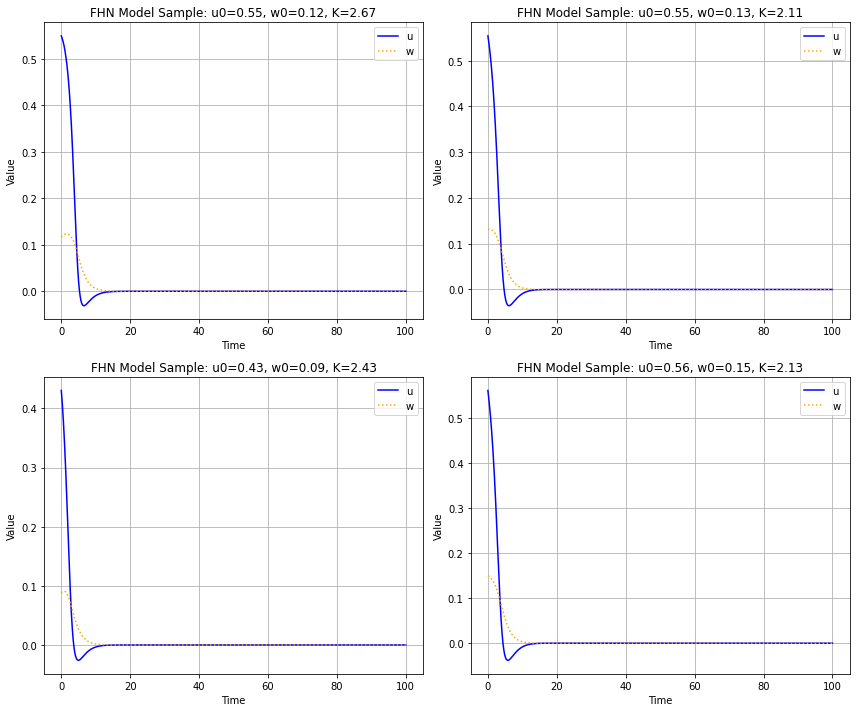

In [277]:
# Randomly select four samples to plot
num_samples = len(training_data)
random_indices = np.random.choice(num_samples, size=4, replace=False)

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Loop through the randomly selected samples and plot their u and w values
for i, idx in enumerate(random_indices):
    axs[i].plot(training_data[idx]['t'], training_data[idx]['u'], label='u', color='blue')
    axs[i].plot(training_data[idx]['t'], training_data[idx]['w'], label='w', color='orange', linestyle='dotted')
    
    # Set labels and title for each subplot
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f"FHN Model Sample: u0={training_data[idx]['u0']:.2f}, w0={training_data[idx]['w0']:.2f}, K={training_data[idx]['K']:.2f}")
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()

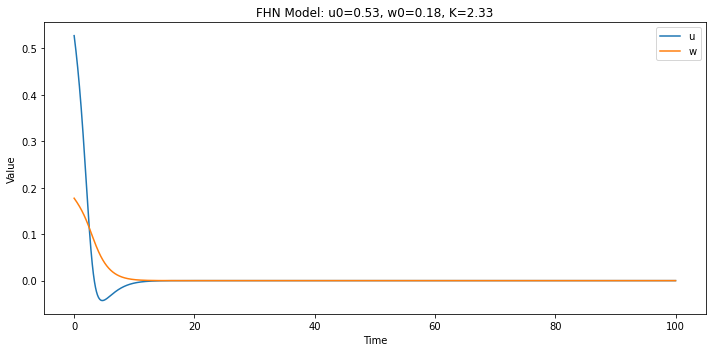

In [278]:
# plot the sample closest to the one in the papaer Define tolerance for closeness
tolerance_u0 = 0.3  # Tolerance for u0
tolerance_w0 = 0.3  # Tolerance for w0
tolerance_K = 0.3

# Find the first sample that meets the criteria within the defined tolerance
sample_to_plot = next((sample for sample in training_data 
                       if abs(sample['u0'] - 0.6) < tolerance_u0 and 
                          abs(sample['w0'] - 0) < tolerance_w0 and 
                          abs(sample['K'] - 2.3) < tolerance_w0), 
                      None)

# Check if a valid sample was found
if sample_to_plot is not None:
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(sample_to_plot['t'], sample_to_plot['u'], label='u')
    ax1.plot(sample_to_plot['t'], sample_to_plot['w'], label='w')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')  # Corrected line
    ax1.legend()
    ax1.set_title(f"FHN Model: u0={sample_to_plot['u0']:.2f}, w0={sample_to_plot['w0']:.2f}, K={sample_to_plot['K']:.2f}")
    plt.tight_layout()
    plt.show()
else:
    print("No sample found close to u0=0.6 and w0=0.")

In [279]:
#helper method to transform generated data to tensors and return it as batches
def Transform_to_Tensors (Data,batch_size):
    t = torch.FloatTensor(Data[0]['t']).reshape(-1, 1).requires_grad_(True)
    U0 = torch.FloatTensor([Data[0]['u0']]).reshape(-1, 1) #Single value
    W0 = torch.FloatTensor([Data[0]['w0']]).reshape(-1, 1)
    K = torch.FloatTensor([Data[0]['K']]).reshape(-1, 1)
    U_true = torch.FloatTensor(Data[0]['u']).reshape(-1, 1)
    W_true = torch.FloatTensor(Data[0]['w']).reshape(-1, 1)
    # Create a TensorDataset
    dataset = TensorDataset(t, U0.expand_as(t), W0.expand_as(t), K.expand_as(t), U_true, W_true)

    # Create DataLoader for batching
    batch_size = 1000  # You can adjust this value
    data_loader= DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader

In [280]:
test_data = Transform_to_Tensors(test_data,1000)

In [281]:
training_data = Transform_to_Tensors(training_data,1000)

In [282]:
validation_data = Transform_to_Tensors(validation_data,1000)

Epoch [1/10], Training Loss : 0.13500607, Validation Loss : 0.16053909
Epoch [2/10], Training Loss : 0.10300946, Validation Loss : 0.15359229
Epoch [3/10], Training Loss : 0.09885781, Validation Loss : 0.14688341
Epoch [4/10], Training Loss : 0.09296364, Validation Loss : 0.13684733
Epoch [5/10], Training Loss : 0.08446128, Validation Loss : 0.12330541
Epoch [6/10], Training Loss : 0.07306060, Validation Loss : 0.10869162
Epoch [7/10], Training Loss : 0.06588858, Validation Loss : 0.09612214
Epoch [8/10], Training Loss : 0.05698829, Validation Loss : 0.08508004
Epoch [9/10], Training Loss : 0.04909692, Validation Loss : 0.07586572
Epoch [10/10], Training Loss : 0.04348535, Validation Loss : 0.06817836
Training Loss Avaergae: 0.00434853, Average Validation Loss : 0.00681784


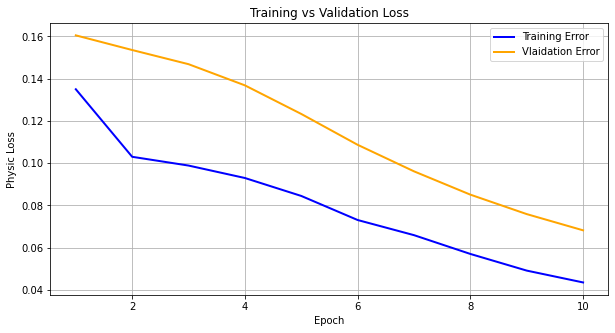

In [283]:
# Training loop
num_epochs = 10
gamma = 0.9999  # Learning rate decay factor

train_errors = []
val_errors=[]
for epoch in range(num_epochs):
    sum_train_errors = 0
    for batch in training_data:
        t_current, U0_current, W0_current, K_current, U_true_current, W_true_current = batch

        # Get predictions
        inputs_current = torch.cat([t_current, U0_current, W0_current, K_current], dim=1)
        U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

        # Calculate physic loss for the current batch
        loss_I = Physic_Loss(t_current, U0_current, W0_current, K_current,U_pred, W_pred)
        sum_train_errors +=loss_I
        # Backpropagation
        optimizer.zero_grad()
        loss_I.backward()
        optimizer.step()
    
    train_errors.append(sum_train_errors)
    sum_val_errors = 0
    #with torch.no_grad():
    for batch in validation_data:
        t_val, U0_val, W0_val, K_val, U_true_val, W_true_val = batch
            
            # Concatenate inputs for the model
        inputs_val = torch.cat([t_val, U0_val, W0_val, K_val], dim=1)

            # Get predictions
        U_pred_val, W_pred_val = MLP_model(inputs_val).split(1, dim=1)

            # Calculate Data loss for the validation batch
            
        loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        
        sum_val_errors+=loss_I  # Store the loss
            
    val_errors.append(sum_val_errors)


    #print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss : {sum_train_errors:.8f}, Validation Loss : {sum_val_errors:.8f}")

print(f"Training Loss Avaergae: {sum_train_errors/len(training_data):.8f}, Average Validation Loss : {sum_val_errors/len(validation_data):.8f}")

# Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_errors, color='blue', label="Training Error",linewidth=2)
plt.plot(range(1, num_epochs + 1), val_errors, color='orange',label="Vlaidation Error", linewidth=2)

plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Physic Loss')
plt.legend()
plt.grid()
plt.show()

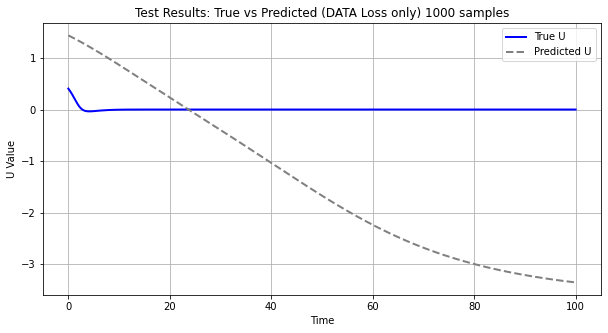

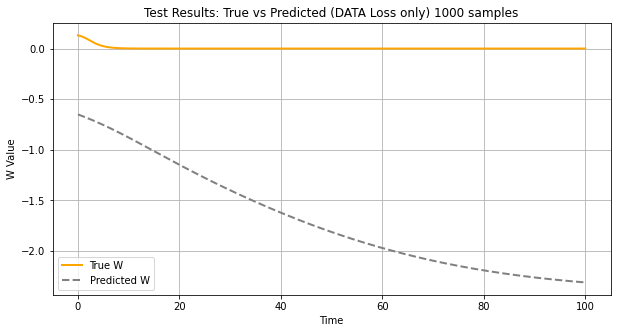

In [284]:
# Plot 
predictions_u = []
predictions_w = []
true_u = []
true_w  = []
Time = []
sum_test_errors=0
for batch in test_data:
    t, U0, W0, K, U_true, W_true = batch

        # Get predictions
    inputs_current = torch.cat([t, U0, W0, K], dim=1)
    U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

    # Calculate physic loss for the current batch
    loss_I = Physic_Loss(t, U0, W0, K,U_pred, W_pred)
    sum_test_errors +=loss_I
    
    # Store predictions and true values for visualization
    predictions_u.append(U_pred.detach().numpy())
    true_u.append(U_true.detach().numpy())
    predictions_w.append(W_pred.detach().numpy())
    true_w.append(W_true.detach().numpy())
    Time.append(t.detach().numpy())



predictions_u=np.concatenate(predictions_u, axis=0).squeeze()
true_u=np.concatenate(true_u, axis=0).squeeze()
predictions_w=np.concatenate(predictions_w, axis=0).squeeze()
true_w=np.concatenate(true_w, axis=0).squeeze()
Time = np.concatenate(Time,axis =0).squeeze()

    # Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(Time, true_u, label='True U', color='blue', linewidth=2)
plt.plot(Time, predictions_u, label='Predicted U', color='gray', linestyle='--', linewidth=2)
plt.title('Test Results: True vs Predicted (DATA Loss only) 1000 samples')
plt.xlabel('Time')
plt.ylabel('U Value')
plt.legend()
plt.grid()

plt.figure(figsize=(10, 5))
plt.plot(Time, true_w, label='True W', color='orange', linewidth=2)
plt.plot(Time, predictions_w, label='Predicted W', color='gray', linestyle='--', linewidth=2)

plt.title('Test Results: True vs Predicted (DATA Loss only) 1000 samples')
plt.xlabel('Time')
plt.ylabel('W Value')
plt.legend()
plt.grid()

plt.show()

Epoch [1/100], Training Loss : 0.03797499, Validation Loss : 0.06177218
Epoch [2/100], Training Loss : 0.03386307, Validation Loss : 0.05640500
Epoch [3/100], Training Loss : 0.03019434, Validation Loss : 0.05185917
Epoch [4/100], Training Loss : 0.02715187, Validation Loss : 0.04796888
Epoch [5/100], Training Loss : 0.02452338, Validation Loss : 0.04460051
Epoch [6/100], Training Loss : 0.02225640, Validation Loss : 0.04164694
Epoch [7/100], Training Loss : 0.02029085, Validation Loss : 0.03903005
Epoch [8/100], Training Loss : 0.01856695, Validation Loss : 0.03668886
Epoch [9/100], Training Loss : 0.01705254, Validation Loss : 0.03457982
Epoch [10/100], Training Loss : 0.01570478, Validation Loss : 0.03266833
Epoch [11/100], Training Loss : 0.01450120, Validation Loss : 0.03092770
Epoch [12/100], Training Loss : 0.01341379, Validation Loss : 0.02933524
Epoch [13/100], Training Loss : 0.01242657, Validation Loss : 0.02787170
Epoch [14/100], Training Loss : 0.01152132, Validation Loss 

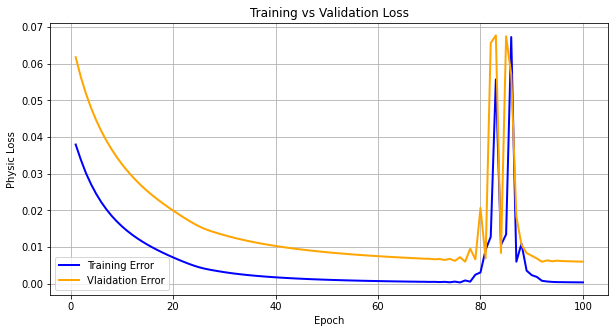

In [285]:
# Training loop
num_epochs = 100
gamma = 0.9999  # Learning rate decay factor

train_errors = []
val_errors=[]
for epoch in range(num_epochs):
    sum_train_errors = 0
    for batch in training_data:
        t_current, U0_current, W0_current, K_current, U_true_current, W_true_current = batch

        # Get predictions
        inputs_current = torch.cat([t_current, U0_current, W0_current, K_current], dim=1)
        U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

        # Calculate physic loss for the current batch
        loss_I = Physic_Loss(t_current, U0_current, W0_current, K_current,U_pred, W_pred)
        sum_train_errors +=loss_I
        # Backpropagation
        optimizer.zero_grad()
        loss_I.backward()
        optimizer.step()
    
    train_errors.append(sum_train_errors)
    sum_val_errors = 0
    #with torch.no_grad():
    for batch in validation_data:
        t_val, U0_val, W0_val, K_val, U_true_val, W_true_val = batch
            
            # Concatenate inputs for the model
        inputs_val = torch.cat([t_val, U0_val, W0_val, K_val], dim=1)

            # Get predictions
        U_pred_val, W_pred_val = MLP_model(inputs_val).split(1, dim=1)

            # Calculate Data loss for the validation batch
            
        loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        
        sum_val_errors+=loss_I  # Store the loss
            
    val_errors.append(sum_val_errors)


    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss : {sum_train_errors:.8f}, Validation Loss : {sum_val_errors:.8f}")

print(f"Training Loss Avaergae: {sum_train_errors/len(training_data):.8f}, Average Validation Loss : {sum_val_errors/len(validation_data):.8f}")

# Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_errors, color='blue', label="Training Error",linewidth=2)
plt.plot(range(1, num_epochs + 1), val_errors, color='orange',label="Vlaidation Error", linewidth=2)

plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Physic Loss')
plt.legend()
plt.grid()
plt.show()

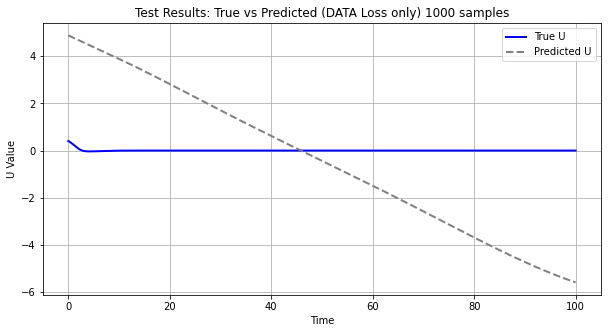

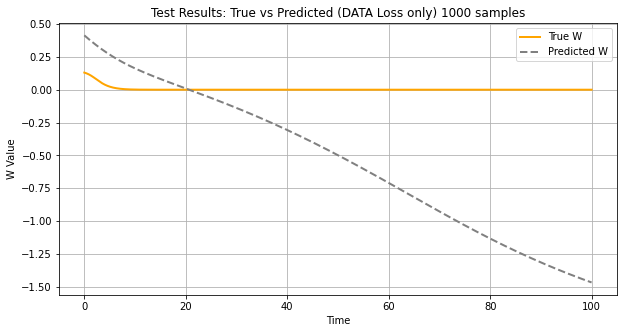

In [286]:
# Plot 
predictions_u = []
predictions_w = []
true_u = []
true_w  = []
Time = []
sum_test_errors=0
for batch in test_data:
    t, U0, W0, K, U_true, W_true = batch

        # Get predictions
    inputs_current = torch.cat([t, U0, W0, K], dim=1)
    U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

    # Calculate physic loss for the current batch
    loss_I = Physic_Loss(t, U0, W0, K,U_pred, W_pred)
    sum_test_errors +=loss_I.detach().numpy() 
    
    # Store predictions and true values for visualization
    predictions_u.append(U_pred.detach().numpy())
    true_u.append(U_true.detach().numpy())
    predictions_w.append(W_pred.detach().numpy())
    true_w.append(W_true.detach().numpy())
    Time.append(t.detach().numpy())



predictions_u=np.concatenate(predictions_u, axis=0).squeeze()
true_u=np.concatenate(true_u, axis=0).squeeze()
predictions_w=np.concatenate(predictions_w, axis=0).squeeze()
true_w=np.concatenate(true_w, axis=0).squeeze()
Time = np.concatenate(Time,axis =0).squeeze()

    # Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(Time, true_u, label='True U', color='blue', linewidth=2)
plt.plot(Time, predictions_u, label='Predicted U', color='gray', linestyle='--', linewidth=2)
plt.title('Test Results: True vs Predicted (DATA Loss only) 1000 samples')
plt.xlabel('Time')
plt.ylabel('U Value')
plt.legend()
plt.grid()

plt.figure(figsize=(10, 5))
plt.plot(Time, true_w, label='True W', color='orange', linewidth=2)
plt.plot(Time, predictions_w, label='Predicted W', color='gray', linestyle='--', linewidth=2)

plt.title('Test Results: True vs Predicted (DATA Loss only) 1000 samples')
plt.xlabel('Time')
plt.ylabel('W Value')
plt.legend()
plt.grid()

plt.show()

Epoch [1/1000], Training Loss : 0.00038813, Validation Loss : 0.00601221
Epoch [2/1000], Training Loss : 0.00037888, Validation Loss : 0.00598690
Epoch [3/1000], Training Loss : 0.00036803, Validation Loss : 0.00595693
Epoch [4/1000], Training Loss : 0.00035935, Validation Loss : 0.00593170
Epoch [5/1000], Training Loss : 0.00035006, Validation Loss : 0.00590362
Epoch [6/1000], Training Loss : 0.00034186, Validation Loss : 0.00587787
Epoch [7/1000], Training Loss : 0.00033336, Validation Loss : 0.00585189
Epoch [8/1000], Training Loss : 0.00032561, Validation Loss : 0.00582721
Epoch [9/1000], Training Loss : 0.00031777, Validation Loss : 0.00580257
Epoch [10/1000], Training Loss : 0.00031048, Validation Loss : 0.00577842
Epoch [11/1000], Training Loss : 0.00030315, Validation Loss : 0.00575453
Epoch [12/1000], Training Loss : 0.00029626, Validation Loss : 0.00573091
Epoch [13/1000], Training Loss : 0.00028938, Validation Loss : 0.00570769
Epoch [14/1000], Training Loss : 0.00028288, Va

Epoch [112/1000], Training Loss : 0.00004037, Validation Loss : 0.00471398
Epoch [113/1000], Training Loss : 0.00004061, Validation Loss : 0.00468056
Epoch [114/1000], Training Loss : 0.00003919, Validation Loss : 0.00471365
Epoch [115/1000], Training Loss : 0.00004001, Validation Loss : 0.00466003
Epoch [116/1000], Training Loss : 0.00003807, Validation Loss : 0.00472109
Epoch [117/1000], Training Loss : 0.00003994, Validation Loss : 0.00463063
Epoch [118/1000], Training Loss : 0.00003721, Validation Loss : 0.00474307
Epoch [119/1000], Training Loss : 0.00004121, Validation Loss : 0.00458433
Epoch [120/1000], Training Loss : 0.00003745, Validation Loss : 0.00479369
Epoch [121/1000], Training Loss : 0.00004624, Validation Loss : 0.00450654
Epoch [122/1000], Training Loss : 0.00004205, Validation Loss : 0.00490396
Epoch [123/1000], Training Loss : 0.00006312, Validation Loss : 0.00437283
Epoch [124/1000], Training Loss : 0.00006340, Validation Loss : 0.00514725
Epoch [125/1000], Trainin

Epoch [222/1000], Training Loss : 0.00192508, Validation Loss : 0.00609798
Epoch [223/1000], Training Loss : 0.00060829, Validation Loss : 0.00524356
Epoch [224/1000], Training Loss : 0.00021390, Validation Loss : 0.00583000
Epoch [225/1000], Training Loss : 0.00007922, Validation Loss : 0.00526322
Epoch [226/1000], Training Loss : 0.00005216, Validation Loss : 0.00554187
Epoch [227/1000], Training Loss : 0.00005416, Validation Loss : 0.00530917
Epoch [228/1000], Training Loss : 0.00004346, Validation Loss : 0.00536317
Epoch [229/1000], Training Loss : 0.00004520, Validation Loss : 0.00527494
Epoch [230/1000], Training Loss : 0.00003875, Validation Loss : 0.00526340
Epoch [231/1000], Training Loss : 0.00003888, Validation Loss : 0.00521351
Epoch [232/1000], Training Loss : 0.00003537, Validation Loss : 0.00519197
Epoch [233/1000], Training Loss : 0.00003486, Validation Loss : 0.00515895
Epoch [234/1000], Training Loss : 0.00003289, Validation Loss : 0.00513944
Epoch [235/1000], Trainin

Epoch [332/1000], Training Loss : 0.00003990, Validation Loss : 0.00515143
Epoch [333/1000], Training Loss : 0.00003880, Validation Loss : 0.00513444
Epoch [334/1000], Training Loss : 0.00003825, Validation Loss : 0.00511336
Epoch [335/1000], Training Loss : 0.00003746, Validation Loss : 0.00509977
Epoch [336/1000], Training Loss : 0.00003702, Validation Loss : 0.00508262
Epoch [337/1000], Training Loss : 0.00003643, Validation Loss : 0.00507165
Epoch [338/1000], Training Loss : 0.00003606, Validation Loss : 0.00505761
Epoch [339/1000], Training Loss : 0.00003559, Validation Loss : 0.00504869
Epoch [340/1000], Training Loss : 0.00003528, Validation Loss : 0.00503701
Epoch [341/1000], Training Loss : 0.00003488, Validation Loss : 0.00502969
Epoch [342/1000], Training Loss : 0.00003461, Validation Loss : 0.00501981
Epoch [343/1000], Training Loss : 0.00003427, Validation Loss : 0.00501377
Epoch [344/1000], Training Loss : 0.00003402, Validation Loss : 0.00500528
Epoch [345/1000], Trainin

Epoch [442/1000], Training Loss : 0.00009052, Validation Loss : 0.00486009
Epoch [443/1000], Training Loss : 0.00003110, Validation Loss : 0.00546335
Epoch [444/1000], Training Loss : 0.00009272, Validation Loss : 0.00401531
Epoch [445/1000], Training Loss : 0.00013113, Validation Loss : 0.00636782
Epoch [446/1000], Training Loss : 0.00021341, Validation Loss : 0.00381603
Epoch [447/1000], Training Loss : 0.00016712, Validation Loss : 0.00618726
Epoch [448/1000], Training Loss : 0.00016809, Validation Loss : 0.00402640
Epoch [449/1000], Training Loss : 0.00008417, Validation Loss : 0.00538982
Epoch [450/1000], Training Loss : 0.00005139, Validation Loss : 0.00458361
Epoch [451/1000], Training Loss : 0.00002423, Validation Loss : 0.00462440
Epoch [452/1000], Training Loss : 0.00002015, Validation Loss : 0.00527353
Epoch [453/1000], Training Loss : 0.00005113, Validation Loss : 0.00418166
Epoch [454/1000], Training Loss : 0.00005744, Validation Loss : 0.00563933
Epoch [455/1000], Trainin

Epoch [552/1000], Training Loss : 0.00001254, Validation Loss : 0.00475329
Epoch [553/1000], Training Loss : 0.00001133, Validation Loss : 0.00478634
Epoch [554/1000], Training Loss : 0.00001457, Validation Loss : 0.00447406
Epoch [555/1000], Training Loss : 0.00001403, Validation Loss : 0.00501093
Epoch [556/1000], Training Loss : 0.00002208, Validation Loss : 0.00442605
Epoch [557/1000], Training Loss : 0.00001664, Validation Loss : 0.00479886
Epoch [558/1000], Training Loss : 0.00001410, Validation Loss : 0.00482817
Epoch [559/1000], Training Loss : 0.00002049, Validation Loss : 0.00429204
Epoch [560/1000], Training Loss : 0.00002644, Validation Loss : 0.00530915
Epoch [561/1000], Training Loss : 0.00004693, Validation Loss : 0.00422471
Epoch [562/1000], Training Loss : 0.00003568, Validation Loss : 0.00481673
Epoch [563/1000], Training Loss : 0.00002871, Validation Loss : 0.00512943
Epoch [564/1000], Training Loss : 0.00005809, Validation Loss : 0.00385336
Epoch [565/1000], Trainin

Epoch [662/1000], Training Loss : 0.00001774, Validation Loss : 0.00448280
Epoch [663/1000], Training Loss : 0.00001227, Validation Loss : 0.00488289
Epoch [664/1000], Training Loss : 0.00001324, Validation Loss : 0.00462581
Epoch [665/1000], Training Loss : 0.00001071, Validation Loss : 0.00463983
Epoch [666/1000], Training Loss : 0.00000930, Validation Loss : 0.00487501
Epoch [667/1000], Training Loss : 0.00001541, Validation Loss : 0.00442154
Epoch [668/1000], Training Loss : 0.00001334, Validation Loss : 0.00499711
Epoch [669/1000], Training Loss : 0.00001920, Validation Loss : 0.00444256
Epoch [670/1000], Training Loss : 0.00001336, Validation Loss : 0.00476814
Epoch [671/1000], Training Loss : 0.00001159, Validation Loss : 0.00478617
Epoch [672/1000], Training Loss : 0.00001583, Validation Loss : 0.00435147
Epoch [673/1000], Training Loss : 0.00001757, Validation Loss : 0.00517202
Epoch [674/1000], Training Loss : 0.00003198, Validation Loss : 0.00422378
Epoch [675/1000], Trainin

Epoch [772/1000], Training Loss : 0.00001358, Validation Loss : 0.00487340
Epoch [773/1000], Training Loss : 0.00001355, Validation Loss : 0.00486311
Epoch [774/1000], Training Loss : 0.00001335, Validation Loss : 0.00486972
Epoch [775/1000], Training Loss : 0.00001337, Validation Loss : 0.00485447
Epoch [776/1000], Training Loss : 0.00001312, Validation Loss : 0.00486795
Epoch [777/1000], Training Loss : 0.00001323, Validation Loss : 0.00484362
Epoch [778/1000], Training Loss : 0.00001289, Validation Loss : 0.00486967
Epoch [779/1000], Training Loss : 0.00001316, Validation Loss : 0.00482837
Epoch [780/1000], Training Loss : 0.00001270, Validation Loss : 0.00487809
Epoch [781/1000], Training Loss : 0.00001331, Validation Loss : 0.00480432
Epoch [782/1000], Training Loss : 0.00001268, Validation Loss : 0.00489993
Epoch [783/1000], Training Loss : 0.00001408, Validation Loss : 0.00476257
Epoch [784/1000], Training Loss : 0.00001342, Validation Loss : 0.00494974
Epoch [785/1000], Trainin

Epoch [882/1000], Training Loss : 0.00002215, Validation Loss : 0.00524400
Epoch [883/1000], Training Loss : 0.00002299, Validation Loss : 0.00521736
Epoch [884/1000], Training Loss : 0.00002059, Validation Loss : 0.00520463
Epoch [885/1000], Training Loss : 0.00002095, Validation Loss : 0.00518120
Epoch [886/1000], Training Loss : 0.00001948, Validation Loss : 0.00517319
Epoch [887/1000], Training Loss : 0.00001964, Validation Loss : 0.00514970
Epoch [888/1000], Training Loss : 0.00001858, Validation Loss : 0.00514515
Epoch [889/1000], Training Loss : 0.00001862, Validation Loss : 0.00512358
Epoch [890/1000], Training Loss : 0.00001782, Validation Loss : 0.00512027
Epoch [891/1000], Training Loss : 0.00001780, Validation Loss : 0.00510085
Epoch [892/1000], Training Loss : 0.00001717, Validation Loss : 0.00509804
Epoch [893/1000], Training Loss : 0.00001713, Validation Loss : 0.00508038
Epoch [894/1000], Training Loss : 0.00001661, Validation Loss : 0.00507823
Epoch [895/1000], Trainin

Epoch [992/1000], Training Loss : 0.00001308, Validation Loss : 0.00496341
Epoch [993/1000], Training Loss : 0.00001294, Validation Loss : 0.00495933
Epoch [994/1000], Training Loss : 0.00001284, Validation Loss : 0.00495335
Epoch [995/1000], Training Loss : 0.00001271, Validation Loss : 0.00494956
Epoch [996/1000], Training Loss : 0.00001261, Validation Loss : 0.00494407
Epoch [997/1000], Training Loss : 0.00001249, Validation Loss : 0.00494046
Epoch [998/1000], Training Loss : 0.00001239, Validation Loss : 0.00493549
Epoch [999/1000], Training Loss : 0.00001228, Validation Loss : 0.00493194
Epoch [1000/1000], Training Loss : 0.00001218, Validation Loss : 0.00492756
Training Loss Avaergae: 0.00000122, Average Validation Loss : 0.00049276


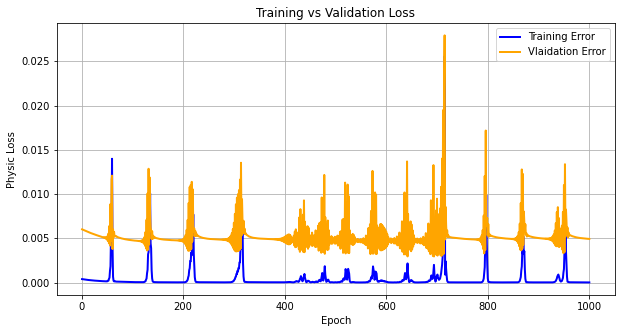

In [287]:
# Training loop
num_epochs = 1000
gamma = 0.9999  # Learning rate decay factor

train_errors = []
val_errors=[]
for epoch in range(num_epochs):
    sum_train_errors = 0
    for batch in training_data:
        t_current, U0_current, W0_current, K_current, U_true_current, W_true_current = batch

        # Get predictions
        inputs_current = torch.cat([t_current, U0_current, W0_current, K_current], dim=1)
        U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

        # Calculate physic loss for the current batch
        loss_I = Physic_Loss(t_current, U0_current, W0_current, K_current,U_pred, W_pred)
        sum_train_errors +=loss_I
        # Backpropagation
        optimizer.zero_grad()
        loss_I.backward()
        optimizer.step()
    
    train_errors.append(sum_train_errors)
    sum_val_errors = 0
    #with torch.no_grad():
    for batch in validation_data:
        t_val, U0_val, W0_val, K_val, U_true_val, W_true_val = batch
            
            # Concatenate inputs for the model
        inputs_val = torch.cat([t_val, U0_val, W0_val, K_val], dim=1)

            # Get predictions
        U_pred_val, W_pred_val = MLP_model(inputs_val).split(1, dim=1)

            # Calculate Data loss for the validation batch
            
        loss_I = Physic_Loss(t_val, U0_val, W0_val, K_val,U_pred_val, W_pred_val)        
        sum_val_errors+=loss_I  # Store the loss
            
    val_errors.append(sum_val_errors)


    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss : {sum_train_errors:.8f}, Validation Loss : {sum_val_errors:.8f}")

print(f"Training Loss Avaergae: {sum_train_errors/len(training_data):.8f}, Average Validation Loss : {sum_val_errors/len(validation_data):.8f}")

# Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_errors, color='blue', label="Training Error",linewidth=2)
plt.plot(range(1, num_epochs + 1), val_errors, color='orange',label="Vlaidation Error", linewidth=2)

plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Physic Loss')
plt.legend()
plt.grid()
plt.show()

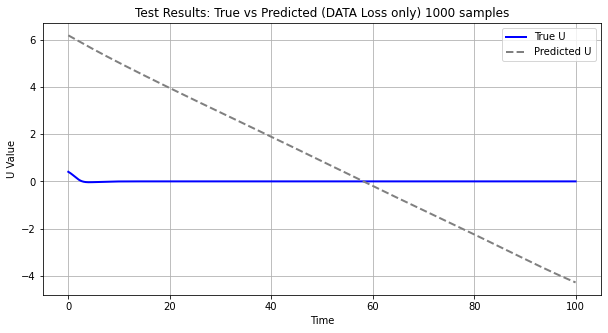

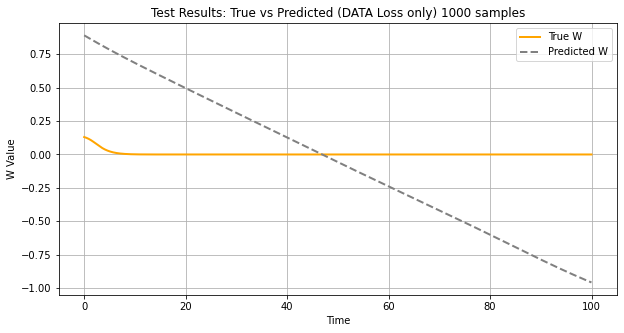

In [288]:
# Plot 
predictions_u = []
predictions_w = []
true_u = []
true_w  = []
Time = []
sum_test_errors=0
for batch in test_data:
    t, U0, W0, K, U_true, W_true = batch

        # Get predictions
    inputs_current = torch.cat([t, U0, W0, K], dim=1)
    U_pred, W_pred = MLP_model(inputs_current).split(1, dim=1)

    # Calculate physic loss for the current batch
    loss_I = Physic_Loss(t, U0, W0, K,U_pred, W_pred)
    sum_test_errors +=loss_I
    
    # Store predictions and true values for visualization
    predictions_u.append(U_pred.detach().numpy())
    true_u.append(U_true.detach().numpy())
    predictions_w.append(W_pred.detach().numpy())
    true_w.append(W_true.detach().numpy())
    Time.append(t.detach().numpy())



predictions_u=np.concatenate(predictions_u, axis=0).squeeze()
true_u=np.concatenate(true_u, axis=0).squeeze()
predictions_w=np.concatenate(predictions_w, axis=0).squeeze()
true_w=np.concatenate(true_w, axis=0).squeeze()
Time = np.concatenate(Time,axis =0).squeeze()

    # Plotting the loss against epochs
plt.figure(figsize=(10, 5))
plt.plot(Time, true_u, label='True U', color='blue', linewidth=2)
plt.plot(Time, predictions_u, label='Predicted U', color='gray', linestyle='--', linewidth=2)
plt.title('Test Results: True vs Predicted (DATA Loss only) 1000 samples')
plt.xlabel('Time')
plt.ylabel('U Value')
plt.legend()
plt.grid()

plt.figure(figsize=(10, 5))
plt.plot(Time, true_w, label='True W', color='orange', linewidth=2)
plt.plot(Time, predictions_w, label='Predicted W', color='gray', linestyle='--', linewidth=2)

plt.title('Test Results: True vs Predicted (DATA Loss only) 1000 samples')
plt.xlabel('Time')
plt.ylabel('W Value')
plt.legend()
plt.grid()

plt.show()